# Blatella Germanica Gene Annotation Workflow
I created this program to make the gene annotation for the ebony gene in Blatella Germanica and genes in various other species faster and easier. Simply give the accession number of the sequence (can be found on the NCBI website) and the identifier for your specific CDS, and the program will output the mRNA sequence, extended gene region (region of the sequence containing your coding sequences), and coordinates of exons in the mRNA and extended gene region sequences (coordinates output format is a .csv file). For more information, please refer to the flow chart below. 
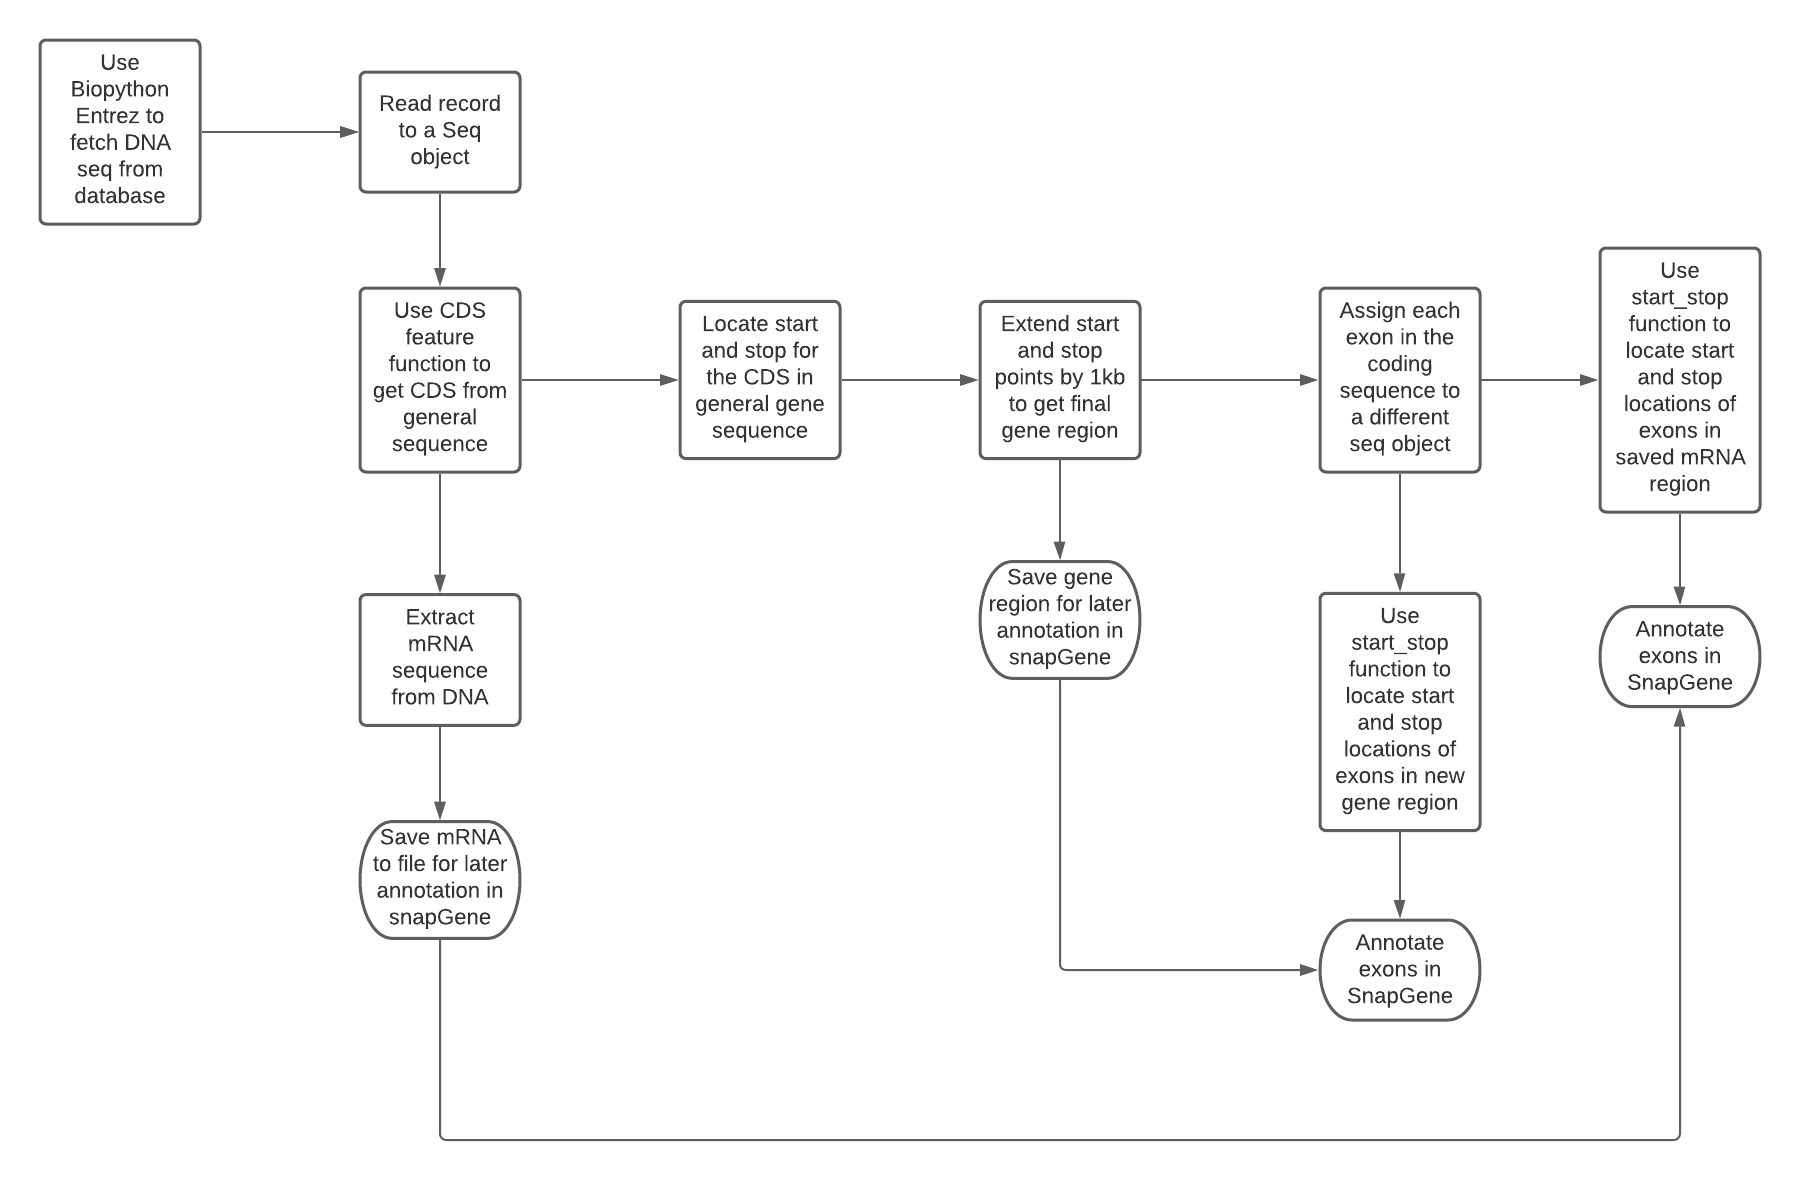

In [1]:
# import necessary modules for workflow

from Bio import SeqIO
import pandas as pd
from datetime import datetime as dt
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation
from Bio import Entrez

# define functions for workflow


## function that pulls appropriate CDS sequence from the obtained sequence

def get_cds_feature_with_qualifier_value(seq_record, name, value):
    """Function to look for CDS feature by annotation value in sequence record.
    
    e.g. You can use this for finding features by locus tag, gene ID, or protein ID.
    """
    # Loop over the features
    for feature in genome_record.features:
        if feature.type == "CDS" and value in feature.qualifiers.get(name, []):
            return feature
    # Could not find it
    return None

def seq_to_FASTA(seq, output):
    seq_record = SeqRecord(seq, id = "randomsequence")
    SeqIO.write(seq_record, output + '.fasta', 'fasta')

def start_stop(seq_1, seq_2):
    if len(seq_1) > len(seq_2):
        main = seq_1
        target = seq_2
    else: 
        main = seq_2
        target = seq_1
    if main.count(target) == 1:
        loc_1 = main.find(target) + 1
        loc_1_final = loc_1 - 1
        loc_2 = loc_1_final + len(target)
        start_end = [loc_1, loc_2]
        return start_end 
    else: 
        return 'Error: This exons is either not present in the sequence or present multiple times'  


In [2]:
# obtain DNA sequence from NCBI database

Entrez.email = "saipra003@gmail.com"  # Always tell NCBI who you are
handle = Entrez.efetch(db="nucleotide", id="PYGN01000205.1", rettype="gb", retmode="text")

# read the obtained sequence from database into a Biopython object

genome_record = SeqIO.read(handle, 'genbank')

In [3]:
# Extract the reverse complement mRNA sequence and save to FASTA file for later annotation in SnapGene
cds_feature = get_cds_feature_with_qualifier_value(handle, "locus_tag", "C0J52_11788")
mRNA_seq = cds_feature.extract(genome_record.seq)

# Save mRNA sequence to file for later use
mRNA_seq_record = SeqRecord(mRNA_seq, id = "randomsequence")
SeqIO.write(mRNA_seq_record, 'mRNA_seq.fasta', 'fasta')

1

In [4]:
#Locate start and stop of CDS sequence to get extended gene region

start = cds_feature.location.start
end = cds_feature.location.end
#extend the start and stop positions by around 1kb

start = start - 1000
end = end + 1000

#Save the extended region for later annotation in SnapGene

dna_seq = genome_record.seq
ext_dna_region = dna_seq[start+1:end+1]
ext_dna_region = ext_dna_region.reverse_complement()
seq_to_FASTA(ext_dna_region, 'Cockaroach Ebony Extended DNA Region')

In [5]:
# Extract the CDS sequences from the main gene region while keeping the sequence for each exon separate
loc_feat = cds_feature.location.parts
loc_feat
exons = []
for feature in loc_feat:
    parts = feature.parts
    for coord in parts:
        lgth = len(coord)
        start = min(coord)
        end = start + lgth
        exons.append(dna_seq[start:end])

In [6]:
coordinates_ext_gene = []

for exon in exons:
    exon = exon.reverse_complement()
    d = start_stop(exon, ext_dna_region)
    coordinates_ext_gene.append(d)

ext_gene_coordinates = pd.DataFrame(coordinates_ext_gene, columns = ['start', 'stop'])

# Write the dataframe to a csv file because it is more portable
ext_gene_coordinates.to_csv('ext_gene_coordinates.csv', index = False)

display(ext_gene_coordinates)

,start,stop
0,1002,2217
1,6497,6738
2,9724,10178
3,11500,11947
4,13672,13809


In [7]:
# Repetition of the same code as above but for mRNA 
coordinates_mRNA = []
for exon in exons:
    exon = exon.reverse_complement()
    r = start_stop(exon, mRNA_seq)
    coordinates_mRNA.append(r)
mRNA_coordinates = pd.DataFrame(coordinates_mRNA, columns = ['start', 'stop'])

# Write the dataframe to a csv file because it is more portable
mRNA_coordinates.to_csv('mRNA_coordinates.csv', index = False)

display(mRNA_coordinates)

,start,stop
0,1,1216
1,1217,1458
2,1459,1913
3,1914,2361
4,2362,2499
